<a href="https://colab.research.google.com/github/GrigoryBartosh/dul_2021/blob/main/Homework/hw8/Homework8_DRE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from torch.utils.data import DataLoader

from datasets.hw8 import MyDataset
from models.hw8 import AVB, MomentMatchDRE
from utils.hw8 import *


# Question 1. KMM

## Notations from practice

*   $p_{nu}(x)$ - pdf of numerator
*   $p_{de}(x)$ - pdf of denominator
*   $r(x)=\frac{p_{nu}(x)}{p_{de}(x)}$ - density ratio
*   $p_{nu}^*, p_{du}^*, r^*$ - estimatinos of respective functions
*   $\{x^{nu}_i\}_{i=1}^{n_{nu}}$ - sample from numerator distribution
*   $\{x^{de}_i\}_{i=1}^{n_{de}}$ - sample from denominator distribution



## KMM objective

Here we will implement Kernel Mean Matching (KMM) method for density ratio estimation. The basic idea of KMM is to 'match' expections of kernel function:

$$argmin_{r^*} ||E_{p_{de}}r^*(x)K(\cdot, x) - E_{p_{nu}}K(\cdot, x)||$$

Where $K(x, x') = exp(-\frac{|x-y|^2}{2\sigma^2})$. Emperical variant of this objective can be rewritten as follows:

$$argmin_{r^*} \frac{1}{n_{de}^2} (r^*_{de})^t K_{de, de} r^*_{de} - \frac{2}{n_{nu}n_{de} }(r^*_{de})^t K_{de, nu}1_{n_{nu}}$$

Where


*   $r^*_{de}$ - vector with $(r^*_{de})_i=r^*(x^{de}_i)$
*   $K_{de, de}$ - matrix with $(K_{de, de})_{i, j} = K(x^{de}_i, x^{de}_j)$
*   $K_{de, nu}$ - matrix with $(K_{de, nu})_{i, j} = K(x^{de}_i, x^{nu}_j)$
*   $1_{n_{nu}}$ - vector with $n_{nu}$ ones


## You will provide these deliverables
Density ratio on $[-2, 2]$.


In [2]:
def q1(data_nu, data_de, batch_size=512, device="cuda"):
    """
    data_nu - An [n_nu] dataset with samples from numerator's distribution
    data_de - An [n_de] dataset with samples from denominators's distribution

    Returns
    - a np.array with density ratios of np.linspace(-2., 2, num=100)
    """
    loader_nu = DataLoader(data_nu, batch_size=batch_size, shuffle=True)
    loader_de = DataLoader(data_de, batch_size=batch_size, shuffle=True)

    model = MomentMatchDRE().to(device)
    model.fit(loader_nu, loader_de)
    
    # you need to calculate density ratio on x and return it
    x = torch.tensor(np.linspace(-2.0, 2.0, num=100).reshape(-1, 1), dtype=torch.float32, device=device)
    return model.predict(x)

100%|██████████| 1000/1000 [00:18<00:00, 55.41it/s]


<Figure size 432x288 with 0 Axes>

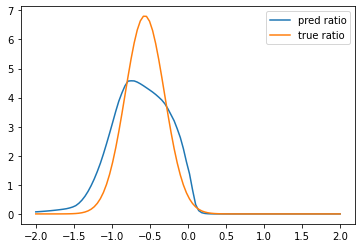

In [3]:
q1_results(q1)

# Question 2. AVB

Here we will implement [Adversairal Variational Bayes](https://dl.acm.org/doi/pdf/10.5555/3305890.3305928).

You may experiment with different hyperparameters and architecture designs, but the following designs for the AVB architecture may be useful.

```
Classifier (T)
    Conv2d(1, 32, 3, 1, 1), 
    ReLU(),
    Conv2d(32, 64, 3, 2, 1),
    ReLU(), 
    Conv2d(64, 128, 3, 2, 1), 
    ReLU(), 
    Conv2d(128, 128, 3, 2, 1), 
    ReLU(),
    # reshape + add latent
    Linear(4 * 4 * 128 + ld, hd), 
    ReLU(),
    Linear(hd, hd), 
    ReLU(),
    Linear(hd, 1)


Encoder (E)

    Conv2d(1, 32, 3, 1, 1), 
    ReLU(),
    Conv2d(32, 64, 3, 2, 1),
    ReLU(), 
    Conv2d(64, 128, 3, 2, 1), 
    ReLU(), 
    Conv2d(128, 128, 3, 2, 1), 
    ReLU(), 
    # add noise + reshape
    Linear(4 * 4 * 128 + nd, ld)

Decoder (D)
    ConvTranspose2d(128, 128, 3, 2, 1), 
    ReLU(), 
    ConvTranspose2d(128, 64, 4, 2, 1), 
    ReLU(), 
    ConvTranspose2d(64, 32, 4, 2, 1), 
    ReLU(), 
    Conv2d(32, 1, 3, 1, 1)
    # reshape
    Linear(ld, 4 * 4 * 128), 
    ReLU()
```

**Reminder.** Objective for AVB

$$max_{\theta, \phi} E \log p_\theta(x|z_\phi(x)) - T(x, z_\phi(x))$$
$$max_{T} E_x \bigg(E_{q_\phi(z|x)} \log\big(\sigma (T(x, z))\big) + E_{p(z)} \log\big(1 - \sigma (T(x, z))\big)\bigg) $$

$\phi$ - parameters of encoder, $\theta$ - parameters of decoder


**You will provide the following deliverables**


1.   Over the course of training, record the elbo and loss of the classifier T ber batch.
2. Report the final test set performances of your final models
3. 100 samples from your trained AVB

In [4]:
def q2(train_data, test_data, epochs=20, batch_size=256, lr=1e-3, noise_dim=4, device="cuda"):
    """
    train_data - A (n_train, 28, 28, 1) uint8 numpy array of binary images with values in {0, 1}
    Returns
    - a (# of training iterations,) numpy array of elbo_losses evaluated every minibatch
    - a (# of training iterations,) numpy array of classifier_losses evaluated every minibatch
    - a torch tensor of size (100, 1, 28, 28) of samples with values in {0, 1}
    """

    trainloader = DataLoader(MyDataset(train_data), batch_size=batch_size, shuffle=True)
    testloader = DataLoader(MyDataset(test_data), batch_size=batch_size)
    
    model = AVB(noise_dim=noise_dim).to(device)
    train_losses, test_losses = model.fit(trainloader, testloader, epochs=epochs, lr=lr)
    
    return train_losses[:, 0], train_losses[:, 1], test_losses[:, 0], test_losses[:, 1], model.sample(100)


Training: 100%|██████████| 20/20 [03:48<00:00, 11.40s/it]  


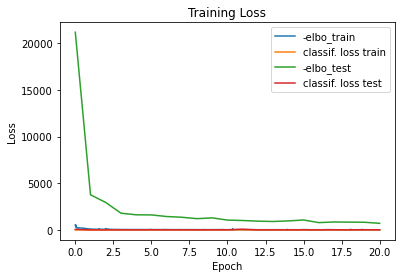

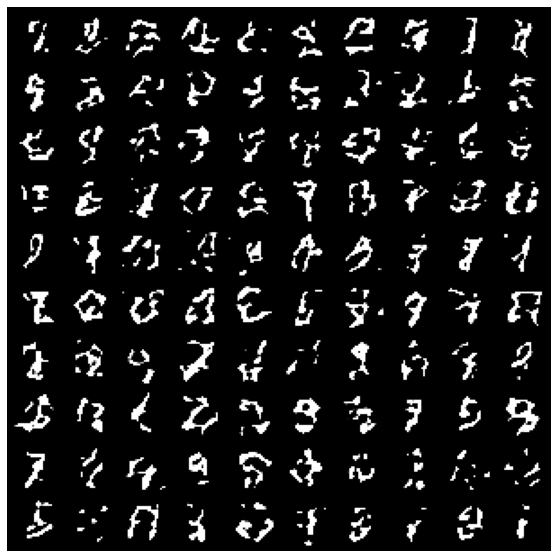

In [5]:
q2_results(q2)